In [ ]:
# Download GSpread to read GSheets data
!pip install --upgrade gspread

from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

Requirement already up-to-date: gspread in /usr/local/lib/python3.7/dist-packages (3.7.0)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
%matplotlib inline
plt.style.use('seaborn')
from scipy.ndimage.filters import gaussian_filter1d
import os
from google.colab import files

In [ ]:
BASE_DIR = '/content/drive/My Drive/4th Year/CS 197 (Thesis)/FINAL - COVID Modeling/notebooks/'
file_path = os.path.join(BASE_DIR, 'data/time_series_covid19_confirmed_global.csv')
confirmed = pd.read_csv(file_path)

# Drop the last column because it's still not complete
confirmed = confirmed.drop(confirmed.columns[-1], axis=1)

In [ ]:
confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,55894,55917,55959,55959,55985,55985,55995,56016,56044,56069,56093,56103,56153,56177,56192,56226,56254,56290,56294,56322,56384,56454,56517,56572,56595,56676,56717,56779,56873,56943,57019,57144,57160,57242,57364,57492,57534,57612,57721,57793
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,114840,115442,116123,116821,117474,118017,118492,118938,119528,120022,120541,121200,121544,121847,122295,122767,123216,123641,124134,124419,124723,125157,125506,125842,126183,126531,126795,126936,127192,127509,127795,128155,128393,128518,128752,128959,129128,129307,129456,129594
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,114681,114851,115008,115143,115265,115410,115540,115688,115842,115970,116066,116157,116255,116349,116438,116543,116657,116750,116836,116946,117061,117192,117304,117429,117524,117622,117739,117879,118004,118116,118251,118378,118516,118645,118799,118975,119142,119323,119486,119642
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,11130,11130,11199,11228,11266,11289,11319,11360,11393,11431,11481,11517,11545,11591,11638,11687,11732,11809,11850,11888,11944,12010,12053,12115,12174,12231,12286,12328,12363,12409,12456,12497,12545,12581,12614,12641,12641,12712,12771,12805
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,21161,21205,21265,21323,21380,21407,21446,21489,21558,21642,21696,21733,21757,21774,21836,21914,21961,22031,22063,22132,22182,22311,22399,22467,22579,22631,22717,22885,23010,23108,23242,23331,23457,23549,23697,23841,23951,24122,24300,24389


##Add population column

In [ ]:
# population_path = os.path.join(BASE_DIR, 'country_populations.gsheet')
popu_url = 'https://docs.google.com/spreadsheets/d/16fShXLT2KvJeINL5l3NFNfuGXVq0_VZFVj9svwKuXgA'
worksheet = gc.open_by_url(popu_url).sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
columns = rows[0]
rows = rows[1:]

In [ ]:
df_popu = pd.DataFrame.from_records(rows, columns=columns)
# df_popu = df_popu.fillna('')
df_popu = df_popu.rename({'Country': 'Country/Region'}, axis=1)
df_popu.head()

,Province/State,Country/Region,Population,,
0,,Afghanistan,"38,928,346",,
1,,Albania,"2,877,797",,
2,,Algeria,"43,851,044",,
3,,Andorra,"77,265",,
4,,Angola,"32,866,272",,


In [ ]:
# Compare the shapes of the confirmed + populations dataframes
print('Confirmed: ' + str(confirmed.shape))
print('Populations: ' + str(df_popu.shape))
df_popu['Population'] = df_popu['Population'].str.replace(',', '').replace('-', '0')
df_popu['Population'] = pd.to_numeric(df_popu['Population'])
df_popu['Population'].dtype

Confirmed: (274, 457)
Populations: (266, 5)


dtype('int64')

In [ ]:
# Merge population with countries
confirmed['Province/State'] = confirmed['Province/State'].fillna('')
confirmed = confirmed.merge(df_popu, on=['Country/Region', 'Province/State'])
confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,Population,,
0,,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,55959,55985,55985,55995,56016,56044,56069,56093,56103,56153,56177,56192,56226,56254,56290,56294,56322,56384,56454,56517,56572,56595,56676,56717,56779,56873,56943,57019,57144,57160,57242,57364,57492,57534,57612,57721,57793,38928346,,
1,,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,116821,117474,118017,118492,118938,119528,120022,120541,121200,121544,121847,122295,122767,123216,123641,124134,124419,124723,125157,125506,125842,126183,126531,126795,126936,127192,127509,127795,128155,128393,128518,128752,128959,129128,129307,129456,129594,2877797,,
2,,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,115143,115265,115410,115540,115688,115842,115970,116066,116157,116255,116349,116438,116543,116657,116750,116836,116946,117061,117192,117304,117429,117524,117622,117739,117879,118004,118116,118251,118378,118516,118645,118799,118975,119142,119323,119486,119642,43851044,,
3,,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,11228,11266,11289,11319,11360,11393,11431,11481,11517,11545,11591,11638,11687,11732,11809,11850,11888,11944,12010,12053,12115,12174,12231,12286,12328,12363,12409,12456,12497,12545,12581,12614,12641,12641,12712,12771,12805,77265,,
4,,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,21323,21380,21407,21446,21489,21558,21642,21696,21733,21757,21774,21836,21914,21961,22031,22063,22132,22182,22311,22399,22467,22579,22631,22717,22885,23010,23108,23242,23331,23457,23549,23697,23841,23951,24122,24300,24389,32866272,,


In [ ]:
# Rearrange columns to put population before the dates
cols = confirmed.columns.tolist()
cols = cols[:4] + [cols[-3]] + cols[4:-3]
confirmed = confirmed[cols]
# Rename populations column
confirmed = confirmed.rename({'Population' : 'populations'}, axis=1)
confirmed.head()

,Province/State,Country/Region,Lat,Long,populations,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,...,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21
0,,Afghanistan,33.93911,67.709953,38928346,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,55894,55917,55959,55959,55985,55985,55995,56016,56044,56069,56093,56103,56153,56177,56192,56226,56254,56290,56294,56322,56384,56454,56517,56572,56595,56676,56717,56779,56873,56943,57019,57144,57160,57242,57364,57492,57534,57612,57721,57793
1,,Albania,41.15330,20.168300,2877797,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,114840,115442,116123,116821,117474,118017,118492,118938,119528,120022,120541,121200,121544,121847,122295,122767,123216,123641,124134,124419,124723,125157,125506,125842,126183,126531,126795,126936,127192,127509,127795,128155,128393,128518,128752,128959,129128,129307,129456,129594
2,,Algeria,28.03390,1.659600,43851044,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,114681,114851,115008,115143,115265,115410,115540,115688,115842,115970,116066,116157,116255,116349,116438,116543,116657,116750,116836,116946,117061,117192,117304,117429,117524,117622,117739,117879,118004,118116,118251,118378,118516,118645,118799,118975,119142,119323,119486,119642
3,,Andorra,42.50630,1.521800,77265,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,11130,11130,11199,11228,11266,11289,11319,11360,11393,11431,11481,11517,11545,11591,11638,11687,11732,11809,11850,11888,11944,12010,12053,12115,12174,12231,12286,12328,12363,12409,12456,12497,12545,12581,12614,12641,12641,12712,12771,12805
4,,Angola,-11.20270,17.873900,32866272,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,21161,21205,21265,21323,21380,21407,21446,21489,21558,21642,21696,21733,21757,21774,21836,21914,21961,22031,22063,22132,22182,22311,22399,22467,22579,22631,22717,22885,23010,23108,23242,23331,23457,23549,23697,23841,23951,24122,24300,24389


In [ ]:
confirmed.to_csv(os.path.join(BASE_DIR, 'data/time_series_covid19_confirmed_global_populations.csv'))

In [ ]:
columns = confirmed.columns

## Get graph of a country

In [ ]:
# Single country / Multiple countries
def get_graph(df, country='Philippines', index=None, startc=7, endc=None):
  try:
    if index:
      df_country = df.loc[index]
    else:
      if isinstance(country, str):
        df_country = df[df['Country/Region'] == country]
      else:
        df_country = df[df['Country/Region'].isin(country)]
  
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    fig.suptitle(df_country['Country/Region'].values[0], fontsize=16)
    ax.set_xlabel("Dates")
    ax.set_ylabel("Cases")
    ax.get_xaxis().set_ticks([])
    # ax.get_yaxis().set_ticks([])

    if endc:
      x = df_country.columns[startc:-endc]
    else:
      x = df_country.columns[startc:]
    y = df_country[x]

    for idx, row in y.iterrows():
      ax.plot(x, row)

    fig.legend(df_country['Country/Region'])

    # ax.plot(x,y)
  except IndexError:
    # No South Korea in the dataset
    print("Country is not in the dataset")

## Daily number of cases


### Removing Negatives

In [ ]:
# Copies the specified columns into a new Dataframe
daily_confirmed = confirmed.copy()

for i in range(6, len(columns)):
    daily = confirmed[columns[i]] - confirmed[columns[i-1]]
    daily_confirmed[columns[i]]=daily

# this whole block deals with negatives by replacing them with the moving average--with that column as the center
daily_columns = daily_confirmed.columns
MEAN_CONSTANT = 4
for idx, col in enumerate(daily_columns[5:], start=5):
  if (daily_confirmed[col] < 0).any():
    neg_cols = daily_confirmed[daily_confirmed[col] < 0][col]
    for country_idx, value in neg_cols.items():
      surrounding = pd.concat([daily_confirmed.loc[country_idx, daily_columns[idx-MEAN_CONSTANT:idx]], 
                            daily_confirmed.loc[country_idx, daily_columns[idx+1:idx+1+MEAN_CONSTANT]]])
      curr_mean = int(surrounding[surrounding >= 0].mean())
      daily_confirmed.loc[country_idx, col] = curr_mean

daily_confirmed.head()

,Province/State,Country/Region,Lat,Long,populations,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,...,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21
0,,Afghanistan,33.93911,67.709953,38928346,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,55894,55917,55959,55959,55985,55985,55995,56016,56044,56069,56093,56103,56153,56177,56192,56226,56254,56290,56294,56322,56384,56454,56517,56572,56595,56676,56717,56779,56873,56943,57019,57144,57160,57242,57364,57492,57534,57612,57721,57793
1,,Albania,41.15330,20.168300,2877797,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,114840,115442,116123,116821,117474,118017,118492,118938,119528,120022,120541,121200,121544,121847,122295,122767,123216,123641,124134,124419,124723,125157,125506,125842,126183,126531,126795,126936,127192,127509,127795,128155,128393,128518,128752,128959,129128,129307,129456,129594
2,,Algeria,28.03390,1.659600,43851044,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,114681,114851,115008,115143,115265,115410,115540,115688,115842,115970,116066,116157,116255,116349,116438,116543,116657,116750,116836,116946,117061,117192,117304,117429,117524,117622,117739,117879,118004,118116,118251,118378,118516,118645,118799,118975,119142,119323,119486,119642
3,,Andorra,42.50630,1.521800,77265,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,11130,11130,11199,11228,11266,11289,11319,11360,11393,11431,11481,11517,11545,11591,11638,11687,11732,11809,11850,11888,11944,12010,12053,12115,12174,12231,12286,12328,12363,12409,12456,12497,12545,12581,12614,12641,12641,12712,12771,12805
4,,Angola,-11.20270,17.873900,32866272,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,21161,21205,21265,21323,21380,21407,21446,21489,21558,21642,21696,21733,21757,21774,21836,21914,21961,22031,22063,22132,22182,22311,22399,22467,22579,22631,22717,22885,23010,23108,23242,23331,23457,23549,23697,23841,23951,24122,24300,24389


In [ ]:
# Index: 224 for negative value in luxembourg. this is just a sanity check to see if our method worked
daily_confirmed[daily_confirmed['Country/Region'] == 'Luxembourg'].values[0, 210:240]

array([7405, 7439, 7458, 7469, 7499, 7566, 7637, 7704, 7762, 7775, 7794,
       7838, 7928, 7928, 6580, 6625, 6625, 6625, 6625, 6745, 6811, 6854,
       6896, 6950, 6960, 6974, 7023, 7088, 7088, 7159], dtype=object)

In [ ]:
# Weird column in Turkey (index 241): 12/10/20 (index 328 of column) - recorded 800k+ (???) cases in one day which I'm sure is impossible.
TURKEY_IDX = 241
COLUMN_IDX = 328
WINDOW_DAYS = 3

# Check the outlier countries
# daily_confirmed.loc[(daily_confirmed.loc[:, daily_confirmed.columns[5:-1]] > 150000).any(axis=1)]

# Replace it with the rolling average again
turkey_mean = daily_confirmed.loc[
                                  TURKEY_IDX, 
                                  daily_columns[COLUMN_IDX-WINDOW_DAYS:COLUMN_IDX].tolist() 
                                  + daily_columns[COLUMN_IDX+1:COLUMN_IDX+1+WINDOW_DAYS].tolist()
                                  ].values.mean()
daily_confirmed.loc[TURKEY_IDX, '12/10/20'] = turkey_mean
daily_confirmed.loc[TURKEY_IDX]

Province/State            
Country/Region      Turkey
Lat                38.9637
Long               35.2433
populations       84339067
                    ...   
4/14/21            4025557
4/15/21            4086957
4/16/21            4150039
4/17/21            4212645
4/18/21            4268447
Name: 241, Length: 458, dtype: object

In [ ]:
# Save daily_confirmed as a csv
daily_confirmed.to_csv(os.path.join(BASE_DIR, 'data/daily_confirmed_filtered.csv'))

## Convert to 5-day moving average

In [ ]:
# Slightly better way of doing a moving average using Pandas' rolling average
def get_moving_average(df, window_size, col_start=6):
  return pd.concat([
                    df[df.columns[:col_start]], 
                    df[df.columns[col_start:]].apply(lambda x: x.rolling(window_size, axis=0).mean(), axis=1).fillna(0, axis=1)
                    ], axis=1)

In [ ]:
NUM_DAYS = 5
moving_average = daily_confirmed.copy()

"""
# Old version of getting the moving average
dates = columns[5:]

for idx, date in enumerate(dates):
  seven_days = dates[idx : idx+NUM_DAYS]
  moving_average[date] = daily_confirmed.apply(lambda x: x[seven_days].mean(), axis=1)
"""

moving_average = get_moving_average(moving_average, NUM_DAYS, col_start=6)
moving_average.head()

,Province/State,Country/Region,Lat,Long,populations,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,...,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21
0,,Afghanistan,33.93911,67.709953,38928346,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.4,...,55866.6,55882.0,55904.4,55921.0,55942.8,55961.0,55976.6,55988.0,56005.0,56021.8,56043.4,56065.0,56092.4,56119.0,56143.6,56170.2,56200.4,56227.8,56251.2,56277.2,56308.8,56348.8,56394.2,56449.8,56504.4,56562.8,56615.4,56667.8,56728.0,56797.6,56866.2,56951.6,57027.8,57101.6,57185.8,57280.4,57358.4,57448.8,57544.6,57630.4
1,,Albania,41.15330,20.168300,2877797,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,113520.8,114193.6,114838.8,115487.0,116140.0,116775.4,117385.4,117948.4,118489.8,118999.4,119504.2,120045.8,120567.0,121030.8,121485.4,121930.6,122333.8,122753.2,123210.6,123635.4,124026.6,124414.8,124787.8,125129.4,125482.2,125843.8,126171.4,126457.4,126727.4,126992.6,127245.4,127517.4,127808.8,128074.0,128322.6,128555.4,128750.0,128932.8,129120.4,129288.8
2,,Algeria,28.03390,1.659600,43851044,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,...,114388.8,114538.2,114693.0,114845.2,114989.6,115135.4,115273.2,115409.2,115549.0,115690.0,115821.2,115944.6,116058.0,116159.4,116253.0,116348.4,116448.4,116547.4,116644.8,116746.4,116850.0,116957.0,117067.8,117186.4,117302.0,117414.2,117523.6,117638.6,117753.6,117872.0,117997.8,118125.6,118253.0,118381.2,118517.8,118662.6,118815.4,118976.8,119145.0,119313.6
3,,Andorra,42.50630,1.521800,77265,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11069.8,11092.0,11123.4,11155.2,11190.6,11222.4,11260.2,11292.4,11325.4,11358.4,11396.8,11436.4,11473.4,11513.0,11554.4,11595.6,11638.6,11691.4,11743.2,11793.2,11844.6,11900.2,11949.0,12002.0,12059.2,12116.6,12171.8,12226.8,12276.4,12323.4,12368.4,12410.6,12454.0,12497.6,12538.6,12575.6,12604.4,12637.8,12675.8,12714.0
4,,Angola,-11.20270,17.873900,32866272,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21104.8,21134.8,21170.6,21213.6,21266.8,21316.0,21364.2,21409.0,21456.0,21508.4,21566.2,21623.6,21677.2,21720.4,21759.2,21802.8,21848.4,21903.2,21961.0,22020.2,22073.8,22143.8,22217.4,22298.2,22387.6,22477.4,22558.6,22655.8,22764.4,22870.2,22992.4,23115.2,23229.6,23337.4,23455.2,23575.0,23699.0,23832.0,23982.2,24120.6


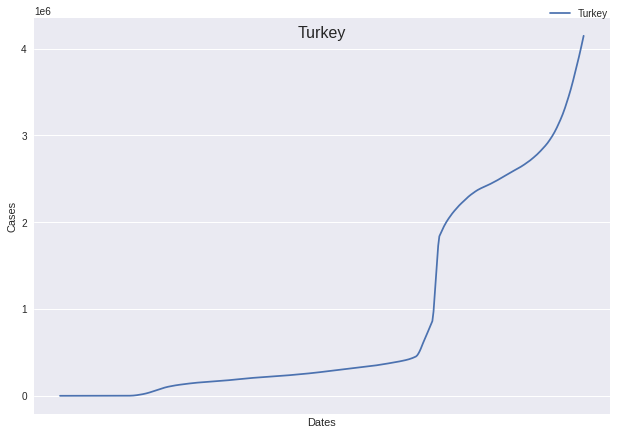

In [ ]:
get_graph(moving_average, country="Turkey")

## Get graph of all areas

In [ ]:
# Combine province/state and country into one column
# moving_average['Province/State']=moving_average['Province/State'].fillna("no province")
moving_average['area']=(moving_average['Province/State']+" "+moving_average['Country/Region']).apply(lambda x: ' '.join(x.split()))
moving_average.head()

,Province/State,Country/Region,Lat,Long,populations,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,...,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,area
0,,Afghanistan,33.93911,67.709953,38928346,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.4,...,55882.0,55904.4,55921.0,55942.8,55961.0,55976.6,55988.0,56005.0,56021.8,56043.4,56065.0,56092.4,56119.0,56143.6,56170.2,56200.4,56227.8,56251.2,56277.2,56308.8,56348.8,56394.2,56449.8,56504.4,56562.8,56615.4,56667.8,56728.0,56797.6,56866.2,56951.6,57027.8,57101.6,57185.8,57280.4,57358.4,57448.8,57544.6,57630.4,Afghanistan
1,,Albania,41.15330,20.168300,2877797,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,114193.6,114838.8,115487.0,116140.0,116775.4,117385.4,117948.4,118489.8,118999.4,119504.2,120045.8,120567.0,121030.8,121485.4,121930.6,122333.8,122753.2,123210.6,123635.4,124026.6,124414.8,124787.8,125129.4,125482.2,125843.8,126171.4,126457.4,126727.4,126992.6,127245.4,127517.4,127808.8,128074.0,128322.6,128555.4,128750.0,128932.8,129120.4,129288.8,Albania
2,,Algeria,28.03390,1.659600,43851044,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,...,114538.2,114693.0,114845.2,114989.6,115135.4,115273.2,115409.2,115549.0,115690.0,115821.2,115944.6,116058.0,116159.4,116253.0,116348.4,116448.4,116547.4,116644.8,116746.4,116850.0,116957.0,117067.8,117186.4,117302.0,117414.2,117523.6,117638.6,117753.6,117872.0,117997.8,118125.6,118253.0,118381.2,118517.8,118662.6,118815.4,118976.8,119145.0,119313.6,Algeria
3,,Andorra,42.50630,1.521800,77265,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11092.0,11123.4,11155.2,11190.6,11222.4,11260.2,11292.4,11325.4,11358.4,11396.8,11436.4,11473.4,11513.0,11554.4,11595.6,11638.6,11691.4,11743.2,11793.2,11844.6,11900.2,11949.0,12002.0,12059.2,12116.6,12171.8,12226.8,12276.4,12323.4,12368.4,12410.6,12454.0,12497.6,12538.6,12575.6,12604.4,12637.8,12675.8,12714.0,Andorra
4,,Angola,-11.20270,17.873900,32866272,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21134.8,21170.6,21213.6,21266.8,21316.0,21364.2,21409.0,21456.0,21508.4,21566.2,21623.6,21677.2,21720.4,21759.2,21802.8,21848.4,21903.2,21961.0,22020.2,22073.8,22143.8,22217.4,22298.2,22387.6,22477.4,22558.6,22655.8,22764.4,22870.2,22992.4,23115.2,23229.6,23337.4,23455.2,23575.0,23699.0,23832.0,23982.2,24120.6,Angola


In [ ]:
def get_graphs(df, areas=['no province Philippines']):
  fig=plt.figure(figsize=(50,20))
  ax=fig.add_axes([0,0,1,1])
  ax.set_xlabel("Dates")
  ax.set_ylabel("Cases")
  for area in areas:
    try:
        df_area = df[df['area'] == area]
        x = df_area.columns[5:-1]
        y=[]
        for i in x:
          y.append(df_area[i].values.sum())
        
        ax.plot(x,y,label=area)
        #comment out the line below to remove the labels of the area names.
        ax.legend()
    except IndexError:
        # No South Korea in the dataset
        print("area is not in the dataset")

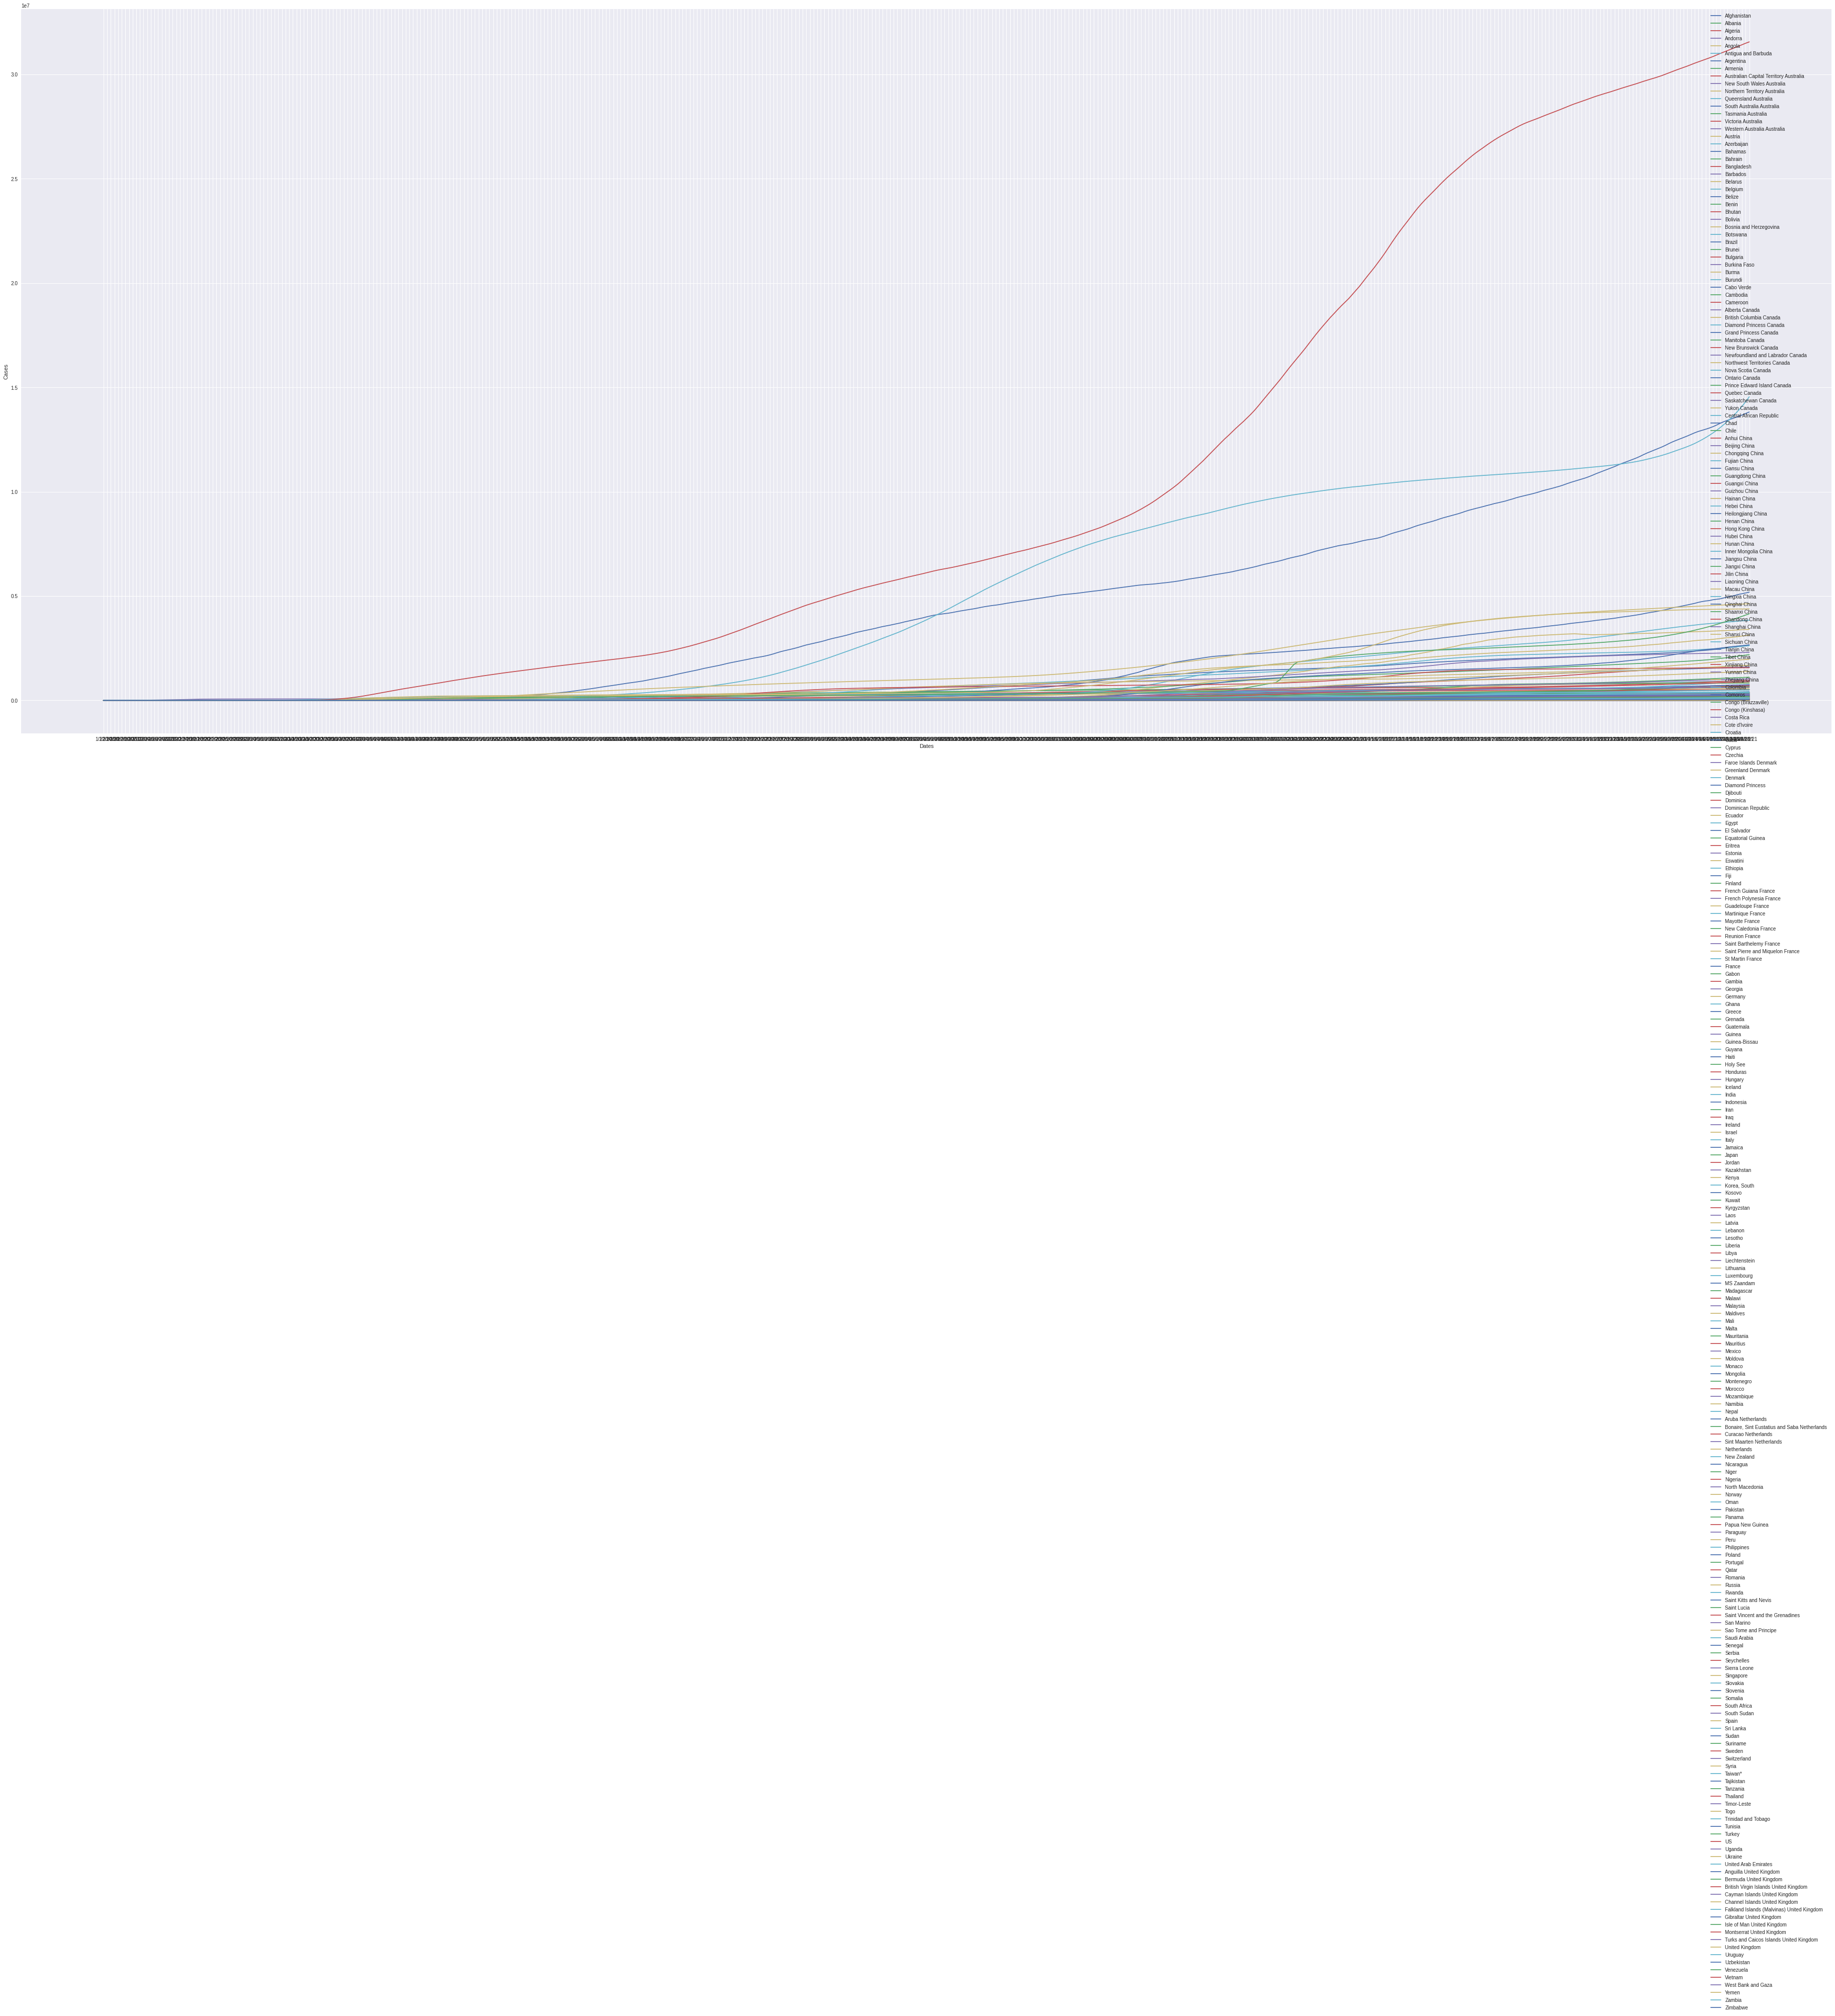

In [ ]:
get_graphs(moving_average, areas=moving_average['area'])

## Scaling Curves by Population

We will then scale the cases according to their population sizes, so as to get the number of cases per capita

### Daily Confirmed

In [ ]:
daily_scaled = daily_confirmed.copy()
daily_scaled.head()

,Province/State,Country/Region,Lat,Long,populations,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,...,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21
0,,Afghanistan,33.93911,67.709953,38928346,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,55894,55917,55959,55959,55985,55985,55995,56016,56044,56069,56093,56103,56153,56177,56192,56226,56254,56290,56294,56322,56384,56454,56517,56572,56595,56676,56717,56779,56873,56943,57019,57144,57160,57242,57364,57492,57534,57612,57721,57793
1,,Albania,41.15330,20.168300,2877797,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,114840,115442,116123,116821,117474,118017,118492,118938,119528,120022,120541,121200,121544,121847,122295,122767,123216,123641,124134,124419,124723,125157,125506,125842,126183,126531,126795,126936,127192,127509,127795,128155,128393,128518,128752,128959,129128,129307,129456,129594
2,,Algeria,28.03390,1.659600,43851044,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,114681,114851,115008,115143,115265,115410,115540,115688,115842,115970,116066,116157,116255,116349,116438,116543,116657,116750,116836,116946,117061,117192,117304,117429,117524,117622,117739,117879,118004,118116,118251,118378,118516,118645,118799,118975,119142,119323,119486,119642
3,,Andorra,42.50630,1.521800,77265,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,11130,11130,11199,11228,11266,11289,11319,11360,11393,11431,11481,11517,11545,11591,11638,11687,11732,11809,11850,11888,11944,12010,12053,12115,12174,12231,12286,12328,12363,12409,12456,12497,12545,12581,12614,12641,12641,12712,12771,12805
4,,Angola,-11.20270,17.873900,32866272,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,21161,21205,21265,21323,21380,21407,21446,21489,21558,21642,21696,21733,21757,21774,21836,21914,21961,22031,22063,22132,22182,22311,22399,22467,22579,22631,22717,22885,23010,23108,23242,23331,23457,23549,23697,23841,23951,24122,24300,24389


In [ ]:
daily_columns = daily_scaled.columns[5:]
for col in daily_columns:
  daily_scaled[col] = daily_scaled[col] / daily_scaled['populations']

daily_scaled.head()

,Province/State,Country/Region,Lat,Long,populations,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,...,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21
0,,Afghanistan,33.93911,67.709953,38928346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.568822e-08,2.568822e-08,...,0.001436,0.001436,0.001437,0.001437,0.001438,0.001438,0.001438,0.001439,0.001440,0.001440,0.001441,0.001441,0.001442,0.001443,0.001443,0.001444,0.001445,0.001446,0.001446,0.001447,0.001448,0.001450,0.001452,0.001453,0.001454,0.001456,0.001457,0.001459,0.001461,0.001463,0.001465,0.001468,0.001468,0.001470,0.001474,0.001477,0.001478,0.001480,0.001483,0.001485
1,,Albania,41.15330,20.168300,2877797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,...,0.039906,0.040115,0.040351,0.040594,0.040821,0.041009,0.041175,0.041330,0.041535,0.041706,0.041887,0.042116,0.042235,0.042340,0.042496,0.042660,0.042816,0.042964,0.043135,0.043234,0.043340,0.043491,0.043612,0.043729,0.043847,0.043968,0.044060,0.044109,0.044198,0.044308,0.044407,0.044532,0.044615,0.044658,0.044740,0.044812,0.044870,0.044933,0.044984,0.045032
2,,Algeria,28.03390,1.659600,43851044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,2.280447e-08,...,0.002615,0.002619,0.002623,0.002626,0.002629,0.002632,0.002635,0.002638,0.002642,0.002645,0.002647,0.002649,0.002651,0.002653,0.002655,0.002658,0.002660,0.002662,0.002664,0.002667,0.002670,0.002673,0.002675,0.002678,0.002680,0.002682,0.002685,0.002688,0.002691,0.002694,0.002697,0.002700,0.002703,0.002706,0.002709,0.002713,0.002717,0.002721,0.002725,0.002728
3,,Andorra,42.50630,1.521800,77265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,...,0.144050,0.144050,0.144943,0.145318,0.145810,0.146108,0.146496,0.147026,0.147454,0.147945,0.148593,0.149058,0.149421,0.150016,0.150624,0.151259,0.151841,0.152838,0.153368,0.153860,0.154585,0.155439,0.155996,0.156798,0.157562,0.158299,0.159011,0.159555,0.160008,0.160603,0.161211,0.161742,0.162363,0.162829,0.163256,0.163606,0.163606,0.164525,0.165288,0.165728
4,,Angola,-11.20270,17.873900,32866272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,...,0.000644,0.000645,0.000647,0.000649,0.000651,0.000651,0.000653,0.000654,0.000656,0.000658,0.000660,0.000661,0.000662,0.000663,0.000664,0.000667,0.000668,0.000670,0.000671,0.000673,0.000675,0.000679,0.000682,0.000684,0.000687,0.000689,0.000691,0.000696,0.000700,0.000703,0.000707,0.000710,0.000714,0.000717,0.000721,0.000725,0.000729,0.000734,0.000739,0.000742


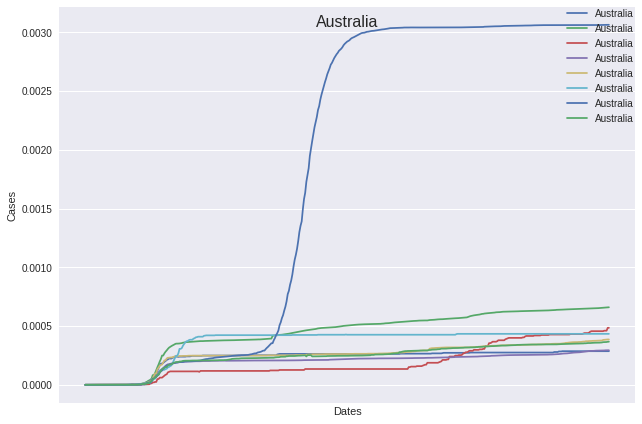

In [ ]:
get_graph(daily_scaled, country='Australia')

### Dividing by Population

In [ ]:
moved_scaled = moving_average.copy()
columns = moved_scaled.columns.tolist()
sorted_columns = columns[:5] + columns[-1::] + columns[5:-1]
moved_scaled = moved_scaled[sorted_columns]
moved_scaled.head()

,Province/State,Country/Region,Lat,Long,populations,area,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,...,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21
0,,Afghanistan,33.93911,67.709953,38928346,Afghanistan,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,...,55866.6,55882.0,55904.4,55921.0,55942.8,55961.0,55976.6,55988.0,56005.0,56021.8,56043.4,56065.0,56092.4,56119.0,56143.6,56170.2,56200.4,56227.8,56251.2,56277.2,56308.8,56348.8,56394.2,56449.8,56504.4,56562.8,56615.4,56667.8,56728.0,56797.6,56866.2,56951.6,57027.8,57101.6,57185.8,57280.4,57358.4,57448.8,57544.6,57630.4
1,,Albania,41.15330,20.168300,2877797,Albania,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,113520.8,114193.6,114838.8,115487.0,116140.0,116775.4,117385.4,117948.4,118489.8,118999.4,119504.2,120045.8,120567.0,121030.8,121485.4,121930.6,122333.8,122753.2,123210.6,123635.4,124026.6,124414.8,124787.8,125129.4,125482.2,125843.8,126171.4,126457.4,126727.4,126992.6,127245.4,127517.4,127808.8,128074.0,128322.6,128555.4,128750.0,128932.8,129120.4,129288.8
2,,Algeria,28.03390,1.659600,43851044,Algeria,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,114388.8,114538.2,114693.0,114845.2,114989.6,115135.4,115273.2,115409.2,115549.0,115690.0,115821.2,115944.6,116058.0,116159.4,116253.0,116348.4,116448.4,116547.4,116644.8,116746.4,116850.0,116957.0,117067.8,117186.4,117302.0,117414.2,117523.6,117638.6,117753.6,117872.0,117997.8,118125.6,118253.0,118381.2,118517.8,118662.6,118815.4,118976.8,119145.0,119313.6
3,,Andorra,42.50630,1.521800,77265,Andorra,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11069.8,11092.0,11123.4,11155.2,11190.6,11222.4,11260.2,11292.4,11325.4,11358.4,11396.8,11436.4,11473.4,11513.0,11554.4,11595.6,11638.6,11691.4,11743.2,11793.2,11844.6,11900.2,11949.0,12002.0,12059.2,12116.6,12171.8,12226.8,12276.4,12323.4,12368.4,12410.6,12454.0,12497.6,12538.6,12575.6,12604.4,12637.8,12675.8,12714.0
4,,Angola,-11.20270,17.873900,32866272,Angola,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21104.8,21134.8,21170.6,21213.6,21266.8,21316.0,21364.2,21409.0,21456.0,21508.4,21566.2,21623.6,21677.2,21720.4,21759.2,21802.8,21848.4,21903.2,21961.0,22020.2,22073.8,22143.8,22217.4,22298.2,22387.6,22477.4,22558.6,22655.8,22764.4,22870.2,22992.4,23115.2,23229.6,23337.4,23455.2,23575.0,23699.0,23832.0,23982.2,24120.6


In [ ]:
moved_columns = moved_scaled.columns[6:]
for col in moved_columns:
  moved_scaled[col] = moved_scaled[col] / moved_scaled['populations']

moved_scaled.head()

,Province/State,Country/Region,Lat,Long,populations,area,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,...,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21
0,,Afghanistan,33.93911,67.709953,38928346,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.137644e-09,...,0.001435,0.001436,0.001436,0.001437,0.001437,0.001438,0.001438,0.001438,0.001439,0.001439,0.001440,0.001440,0.001441,0.001442,0.001442,0.001443,0.001444,0.001444,0.001445,0.001446,0.001446,0.001448,0.001449,0.001450,0.001451,0.001453,0.001454,0.001456,0.001457,0.001459,0.001461,0.001463,0.001465,0.001467,0.001469,0.001471,0.001473,0.001476,0.001478,0.001480
1,,Albania,41.15330,20.168300,2877797,Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.039447,0.039681,0.039905,0.040130,0.040357,0.040578,0.040790,0.040986,0.041174,0.041351,0.041526,0.041714,0.041896,0.042057,0.042215,0.042369,0.042510,0.042655,0.042814,0.042962,0.043098,0.043233,0.043362,0.043481,0.043604,0.043729,0.043843,0.043942,0.044036,0.044128,0.044216,0.044311,0.044412,0.044504,0.044591,0.044671,0.044739,0.044803,0.044868,0.044926
2,,Algeria,28.03390,1.659600,43851044,Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.002609,0.002612,0.002616,0.002619,0.002622,0.002626,0.002629,0.002632,0.002635,0.002638,0.002641,0.002644,0.002647,0.002649,0.002651,0.002653,0.002656,0.002658,0.002660,0.002662,0.002665,0.002667,0.002670,0.002672,0.002675,0.002678,0.002680,0.002683,0.002685,0.002688,0.002691,0.002694,0.002697,0.002700,0.002703,0.002706,0.002710,0.002713,0.002717,0.002721
3,,Andorra,42.50630,1.521800,77265,Andorra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.143271,0.143558,0.143964,0.144376,0.144834,0.145246,0.145735,0.146152,0.146579,0.147006,0.147503,0.148015,0.148494,0.149007,0.149542,0.150076,0.150632,0.151316,0.151986,0.152633,0.153298,0.154018,0.154650,0.155336,0.156076,0.156819,0.157533,0.158245,0.158887,0.159495,0.160078,0.160624,0.161186,0.161750,0.162280,0.162759,0.163132,0.163564,0.164056,0.164551
4,,Angola,-11.20270,17.873900,32866272,Angola,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.000642,0.000643,0.000644,0.000645,0.000647,0.000649,0.000650,0.000651,0.000653,0.000654,0.000656,0.000658,0.000660,0.000661,0.000662,0.000663,0.000665,0.000666,0.000668,0.000670,0.000672,0.000674,0.000676,0.000678,0.000681,0.000684,0.000686,0.000689,0.000693,0.000696,0.000700,0.000703,0.000707,0.000710,0.000714,0.000717,0.000721,0.000725,0.000730,0.000734


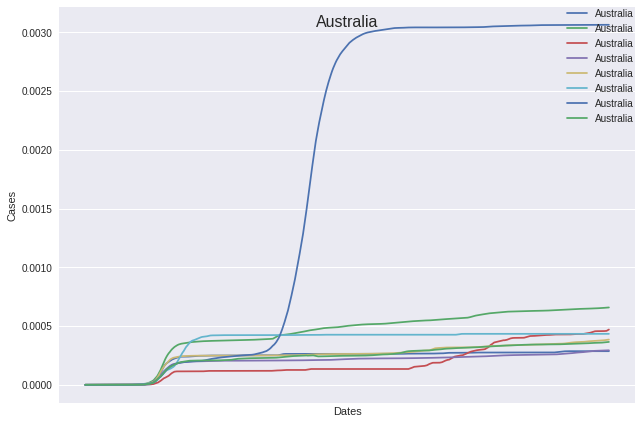

In [ ]:
get_graph(moved_scaled, country='Australia', startc=6)

### Get graph of all areas

In [ ]:
# Combine province/state and country into one column
moved_scaled['Province/State']=moved_scaled['Province/State'].fillna("no province")
moved_scaled['area']=moved_scaled['Province/State']+" "+moved_scaled['Country/Region']
moved_scaled = moved_scaled[~moved_scaled.area.str.contains("Diamond Princess")]
moved_scaled.head()

,Province/State,Country/Region,Lat,Long,populations,area,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,...,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21
0,,Afghanistan,33.93911,67.709953,38928346,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.137644e-09,...,0.001435,0.001436,0.001436,0.001437,0.001437,0.001438,0.001438,0.001438,0.001439,0.001439,0.001440,0.001440,0.001441,0.001442,0.001442,0.001443,0.001444,0.001444,0.001445,0.001446,0.001446,0.001448,0.001449,0.001450,0.001451,0.001453,0.001454,0.001456,0.001457,0.001459,0.001461,0.001463,0.001465,0.001467,0.001469,0.001471,0.001473,0.001476,0.001478,0.001480
1,,Albania,41.15330,20.168300,2877797,Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.039447,0.039681,0.039905,0.040130,0.040357,0.040578,0.040790,0.040986,0.041174,0.041351,0.041526,0.041714,0.041896,0.042057,0.042215,0.042369,0.042510,0.042655,0.042814,0.042962,0.043098,0.043233,0.043362,0.043481,0.043604,0.043729,0.043843,0.043942,0.044036,0.044128,0.044216,0.044311,0.044412,0.044504,0.044591,0.044671,0.044739,0.044803,0.044868,0.044926
2,,Algeria,28.03390,1.659600,43851044,Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.002609,0.002612,0.002616,0.002619,0.002622,0.002626,0.002629,0.002632,0.002635,0.002638,0.002641,0.002644,0.002647,0.002649,0.002651,0.002653,0.002656,0.002658,0.002660,0.002662,0.002665,0.002667,0.002670,0.002672,0.002675,0.002678,0.002680,0.002683,0.002685,0.002688,0.002691,0.002694,0.002697,0.002700,0.002703,0.002706,0.002710,0.002713,0.002717,0.002721
3,,Andorra,42.50630,1.521800,77265,Andorra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.143271,0.143558,0.143964,0.144376,0.144834,0.145246,0.145735,0.146152,0.146579,0.147006,0.147503,0.148015,0.148494,0.149007,0.149542,0.150076,0.150632,0.151316,0.151986,0.152633,0.153298,0.154018,0.154650,0.155336,0.156076,0.156819,0.157533,0.158245,0.158887,0.159495,0.160078,0.160624,0.161186,0.161750,0.162280,0.162759,0.163132,0.163564,0.164056,0.164551
4,,Angola,-11.20270,17.873900,32866272,Angola,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.000642,0.000643,0.000644,0.000645,0.000647,0.000649,0.000650,0.000651,0.000653,0.000654,0.000656,0.000658,0.000660,0.000661,0.000662,0.000663,0.000665,0.000666,0.000668,0.000670,0.000672,0.000674,0.000676,0.000678,0.000681,0.000684,0.000686,0.000689,0.000693,0.000696,0.000700,0.000703,0.000707,0.000710,0.000714,0.000717,0.000721,0.000725,0.000730,0.000734


In [ ]:
moved_scaled.to_csv(os.path.join(BASE_DIR, 'data/normalized_5day_moving.csv'))

In [ ]:
get_graphs(moved_scaled, areas=moved_scaled['area'])

In [ ]:
for i in moved_scaled.iterrows():
    if i[1]['2/6/20']>0.02:
        print(i)

Output hidden; open in https://colab.research.google.com to view.

## K-Means Silhouette value

In [ ]:
# Get only the date columns
copy_moving_average = moving_average.drop(['Province/State','Country/Region','Lat','Long','area'], axis=1)
copy_moving_average.head()

,populations,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,...,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20,9/27/20,9/28/20,9/29/20,9/30/20,10/1/20,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20
0,38928346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,...,31.8,40.4,50.2,46.4,48.0,49.6,41.6,29.4,39.2,45.6,48.6,49.8,46.2,33.4,29.4,45.8,43.8,44.8,52.4,50.2,28.4,23.6,26.2,17.6,16.8,16.4,18.6,12.6,12.8,17.4,30.8,40.2,51.6,63.8,70.4,56.2,54.25,51.666667,43.5,10.0
1,2877797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,117.8,129.8,135.6,141.8,147.4,151.6,153.2,155.8,160.0,163.2,162.4,159.0,152.6,144.0,141.2,142.6,143.8,143.6,142.8,139.0,132.0,123.6,118.6,120.8,119.4,120.8,130.6,141.2,145.2,149.6,152.2,152.4,153.0,156.4,160.0,164.2,165.75,167.000000,166.0,165.0
2,43851044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.2,0.2,0.2,0.0,0.4,0.8,2.2,...,315.4,306.2,299.0,293.8,288.6,283.4,277.6,270.8,263.2,256.0,249.2,242.8,237.4,231.8,225.4,218.4,211.4,204.0,197.4,191.2,185.6,178.2,170.6,162.6,157.8,155.2,155.2,156.0,156.4,153.6,148.0,141.8,134.6,132.6,133.6,134.0,135.25,140.000000,141.0,136.0
3,77265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.2,...,7.8,6.2,12.4,12.4,17.2,17.2,25.8,16.6,16.6,27.4,27.4,27.8,27.8,44.0,25.2,25.2,39.6,39.6,37.8,37.8,54.4,31.0,31.0,42.6,42.6,42.8,42.8,54.8,28.8,28.8,64.0,64.0,91.6,91.6,117.2,65.2,81.50,42.666667,64.0,0.0
4,32866272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,56.2,47.2,40.8,45.6,43.2,56.4,62.8,70.8,71.0,69.4,70.4,79.2,90.8,92.0,92.4,84.4,88.4,89.4,103.0,114.8,119.8,111.0,96.4,86.8,86.0,76.4,88.4,98.6,114.6,99.4,111.6,122.2,102.8,117.6,125.8,143.2,130.25,173.666667,144.0,215.0


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

sillhoute_scores = []
n_cluster_list = np.arange(2,31).astype(int)

In [ ]:
X = copy_moving_average.values.copy()

In [ ]:
sc = MinMaxScaler()
X = sc.fit_transform(X)

In [ ]:
for n_cluster in n_cluster_list:
    
    kmeans = KMeans(n_clusters=n_cluster)
    cluster_found = kmeans.fit_predict(X)
    sillhoute_scores.append(silhouette_score(X, kmeans.labels_))

In [ ]:
sillhoute_scores

[0.9525914545967455,
 0.9466970084722068,
 0.9298254146455504,
 0.882443096587607,
 0.8787463753596475,
 0.8399427874147232,
 0.8419749277770281,
 0.8429608314198701,
 0.8327548845699131,
 0.8318435502073724,
 0.8298473806422767,
 0.8302446585078506,
 0.6348934449227515,
 0.6361248643069175,
 0.6354415514495828,
 0.635022928036669,
 0.6460064676625461,
 0.6189269025484098,
 0.5930366150396869,
 0.5928981770948618,
 0.5981020064978417,
 0.5958055621713946,
 0.569978254973032,
 0.5678137559489732,
 0.5581181511561546,
 0.547229872988747,
 0.5465613037393234,
 0.5790734390355544,
 0.5525963922228644]